# **Notebook 5: Sales Price Prediction**

## Objectives

* Train a ML pipeline using tuning with the best features to predict a property's sale price.

## Tasks

* Loading Data from cleaned data outputs
* Creating the ML Regressor Pipelines
* Split Train and Test sets
* Grid Search CV - Sklearn

## Additional Comments

* This notebook was informed and guided by the steps provided in the Customer Churn Walkthrough Porject.

* We intend to explore the data using the CRISP-DM Data methodology.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
# os.chdir('workspace') 
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues-PP5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues-PP5'

# Import Packages

In [5]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

---

# Load House Price Records

Read the house_prices_records dataset csv file into a Pandas dataframe.

In [6]:
df = pd.read_csv(f"outputs/datasets/cleaned/clean_house_price_records.csv")
print(df.shape)
df.head()


(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,No,706,GLQ,150,548,RFn,2003,1710,Gd,8450,65,196,61,5,7,856,2003,2003,208500
1,1262,0,3,Gd,978,ALQ,284,460,RFn,1976,1262,TA,9600,80,0,0,8,6,1262,1976,1976,181500
2,920,866,3,Mn,486,GLQ,434,608,RFn,2001,1786,Gd,11250,68,162,42,5,7,920,2001,2002,223500
3,961,0,0,No,216,ALQ,540,642,Unf,1998,1717,Gd,9550,60,0,35,5,7,756,1915,1970,140000
4,1145,0,4,Av,655,GLQ,490,836,RFn,2000,2198,Gd,14260,84,350,84,5,8,1145,2000,2000,250000


---

# ML Regressor Pipeline

* Here we create the ML pipeline for Data Cleaning and Feature Engineering

In [7]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

selection_method = "cardinality"
corr_method = "spearman"

def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                   variables=['BsmtExposure',
                                                              'BsmtFinType1',
                                                              'GarageFinish',
                                                              'KitchenQual'])),

      ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF',
                                                           'LotArea',
                                                           'GrLivArea'])),
      ("NumericPowerTransform", vt.PowerTransformer(variables=['MasVnrArea'])),
      ("NumericYeoJohnsonTransform",
       vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])),

      ("SmartCorrelatedSelection",
       SmartCorrelatedSelection(variables=None,
                                method=corr_method,
                                threshold=0.6,
                                selection_method=selection_method
                                )),
    
      ("feat_scaling", StandardScaler()),

      ("feat_selection",  SelectFromModel(model)),

      ("model", model),

    ])

    return pipeline_base

## Hyperparameter Optimisation

* Custom Class for hyperparameter Optimization

In [8]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test datasets

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


---

## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimization search using default hyperparameters.

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check the results produced.

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.676578,0.797595,0.858455,0.070901
2,RandomForestRegressor,0.701255,0.79697,0.844212,0.055843
5,GradientBoostingRegressor,0.608028,0.777112,0.841748,0.087197
6,XGBRegressor,0.657313,0.746709,0.797495,0.047457
0,LinearRegression,0.672906,0.74566,0.802878,0.048261
4,AdaBoostRegressor,0.615186,0.715069,0.775404,0.053264
1,DecisionTreeRegressor,0.312063,0.551501,0.648486,0.122515


* Client business requirement is an R2 score of at least 0.75
* The best result is RandomForestRegressor with an average R2 score around 0.80
* Applying an extensive search may improve the score

---

## Extensive Search

* Conduct an extensive search on most suitable model to find the best hyperparameter configuration.

### Define model and parameters, for Extensive Search

In [13]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [100,700],
        'model__max_depth': [6,18,None],
    }
}

Extensive GridSearch CV

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Check results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
2,RandomForestRegressor,0.701648,0.798367,0.844596,0.054706,18,100
3,RandomForestRegressor,0.6941,0.797423,0.848768,0.059361,18,700
4,RandomForestRegressor,0.701255,0.79697,0.844212,0.055843,None,100
5,RandomForestRegressor,0.692762,0.796961,0.848519,0.059702,None,700
0,RandomForestRegressor,0.684103,0.78803,0.8418,0.06023,6,100
1,RandomForestRegressor,0.681116,0.786042,0.83986,0.062383,6,700


* The above extensive search improved the score, but only very slightly.

* Nevertheless, the client business requirement of 0.75 has been satisfied with a score of 0.80

---

Establishing the best model

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 18, 'model__n_estimators': 100}

Define the best regressor, based on search

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'LotArea',
                                           'GrLivArea'])),
                ('NumericPowerTransform',
                 PowerTransformer(variables=['MasVnrArea'])),
                ('NumericYeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['OpenPorchSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='cardinality',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model', RandomForestRegressor(max_depth=18, random_state=0))])

---

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['1stFlrSF', 'GarageArea', 'GrLivArea', 'YearBuilt']


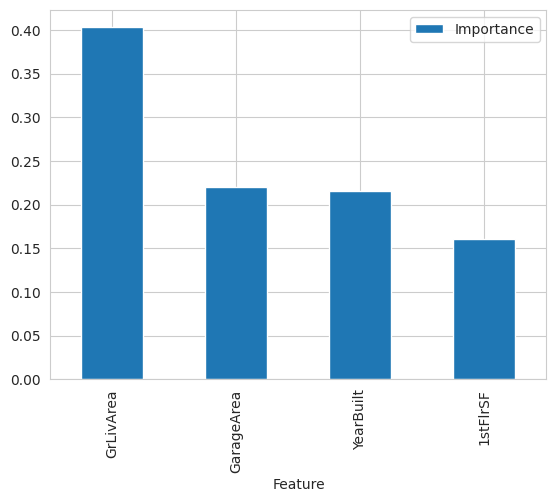

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

# Following data cleaning and feature engineering, the feature shows changes
data_cleaning_feat_eng_steps = 5 # how many data cleaning and feature engineering does your pipeline hold?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

---

## Evaluate Pipeline Performance

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Evaluate Performance on Train and Test sets

Model Evaluation 

* Train Set
R2 Score: 0.97
Mean Absolute Error: 8525.305
Mean Squared Error: 186837667.172
Root Mean Squared Error: 13668.858


* Test Set
R2 Score: 0.783
Mean Absolute Error: 24153.815
Mean Squared Error: 1496472434.494
Root Mean Squared Error: 38684.266




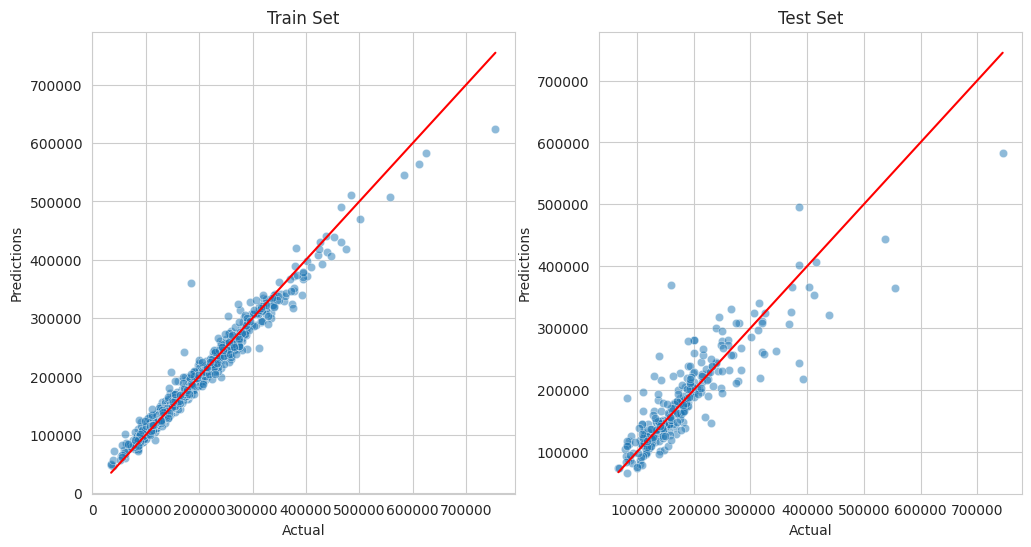

In [21]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Applying Regressor with Principal Component Analysis

Explore potential values for PCA n_components.

In [22]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:6])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


Apply Principal Component Analysis separately to the scaled data

* The 17 components explain 100.0% of the data 



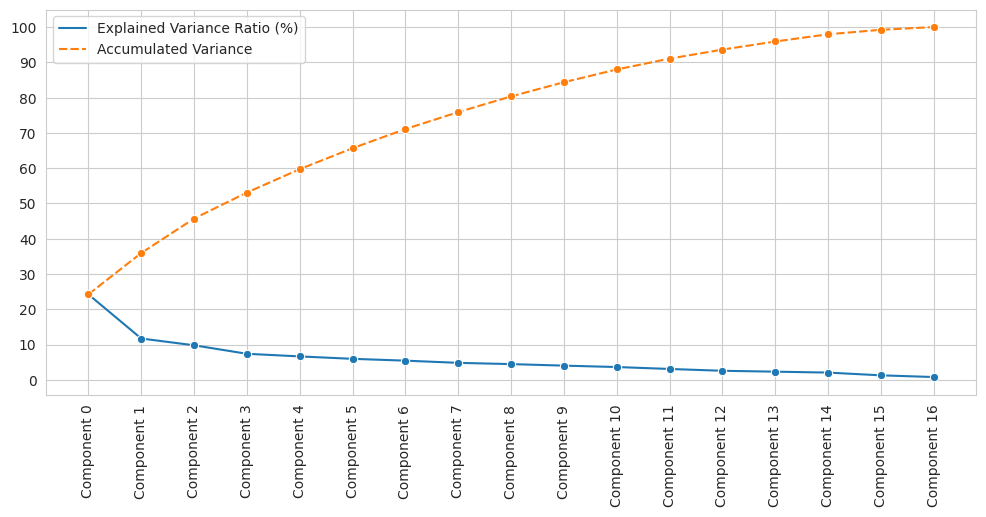

In [23]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12,5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)

* The 9 components explain 80.34% of the data 



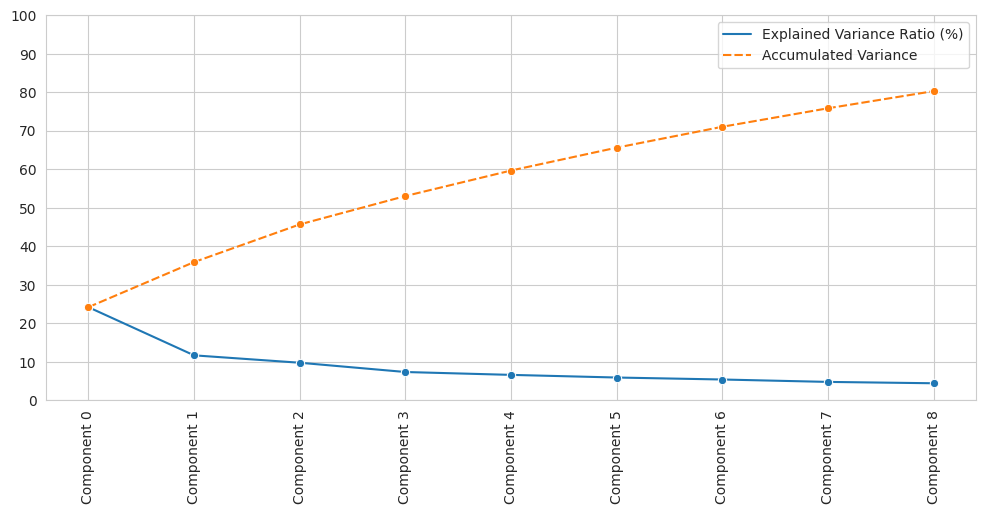

In [24]:
n_components = 9
pca_components_analysis(df_pca=df_pca,n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [25]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                   variables=['BsmtExposure',
                                                              'BsmtFinType1',
                                                              'GarageFinish',
                                                              'KitchenQual'])),

      ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF',
                                                           'LotArea',
                                                           'GrLivArea'])),
      ("NumericPowerTransform", vt.PowerTransformer(variables=['GarageArea',
                                                               'MasVnrArea'])),
      ("NumericYeoJohnsonTransform",
       vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])),

      ("SmartCorrelatedSelection",
       SmartCorrelatedSelection(variables=None,
                                method=corr_method,
                                threshold=0.6,
                                selection_method=selection_method
                                )),

      ("feat_scaling", StandardScaler()),

      ("PCA", PCA(n_components=n_components, random_state=0)),

      ("model", model),

    ])

    return pipeline_base

## Grid Search CV – Sklearn

In [26]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Use standard hyperparameters to find most suitable model

In [27]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

We can do a quick optimization search.

In [28]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Results check

In [29]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.729657,0.786499,0.821848,0.031637
5,GradientBoostingRegressor,0.712058,0.782249,0.816912,0.036346
3,ExtraTreesRegressor,0.651892,0.768458,0.824174,0.062635
6,XGBRegressor,0.675336,0.754652,0.789408,0.044909
4,AdaBoostRegressor,0.688372,0.742515,0.768837,0.029308
0,LinearRegression,0.648534,0.724851,0.792781,0.047302
1,DecisionTreeRegressor,0.478543,0.610167,0.651408,0.066089


### Do extensive search on most feasible model to helps locate the best hyperparameter configuration

Define model and parameters for extensive search

models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [100,700],
        'model__max_depth': [6,18,None],
    }
}

Extensive GridSearch CV

In [30]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Check results

In [31]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
2,RandomForestRegressor,0.73474,0.787408,0.827112,0.031191,18,100
4,RandomForestRegressor,0.729657,0.786499,0.821848,0.031637,None,100
5,RandomForestRegressor,0.731361,0.78571,0.829403,0.033222,None,700
3,RandomForestRegressor,0.729946,0.785168,0.831081,0.034152,18,700
0,RandomForestRegressor,0.724691,0.780085,0.819108,0.032099,6,100
1,RandomForestRegressor,0.721957,0.778939,0.824745,0.034888,6,700


Check the best model

In [32]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Parameters for best model

In [33]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 18, 'model__n_estimators': 100}

Define the best regressor

In [34]:
best_regressor_pipeline_pca = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline_pca

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'LotArea',
                                           'GrLivArea'])),
                ('NumericPowerTransform',
                 PowerTransformer(variables=['GarageArea', 'MasVnrArea'])),
                ('NumericYeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['OpenPorchSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='cardinality',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=9, random_state=0)),
                ('model', RandomForestRegressor(max_depth=18, random_state=0))])

---

## Evaluate Regressor on Train and Tests datasets

Model Evaluation 

* Train Set
R2 Score: 0.967
Mean Absolute Error: 8811.979
Mean Squared Error: 201079086.949
Root Mean Squared Error: 14180.236


* Test Set
R2 Score: 0.745
Mean Absolute Error: 23671.175
Mean Squared Error: 1758837775.264
Root Mean Squared Error: 41938.5




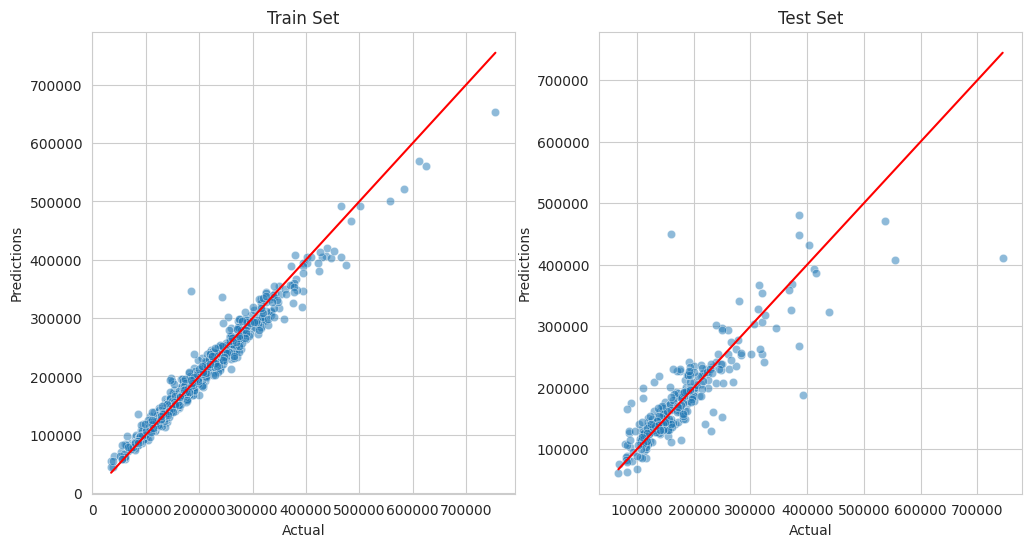

In [35]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline_pca)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline_pca)

---

# Regressor Model Analysis findings

* A Regressor model was chosen to predict sale price for a given property.

* Both feature selection and PCA produced close results and met business requirement 1. Despite by a small margin, feature 
selection performed better. Therefore, the best pipeline to use will be that of feature selection in this case. 

* Feature selection achieved an R2 Score: 0.97 on the train set and an R2 Score: 0.78 on the test set.

* The client requirement is for an R2 Score of 0.75\n"

---

## Best Features for the Subsets

In [36]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head()

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,1stFlrSF,GarageArea,GrLivArea,YearBuilt
618,1828,774,1828,2007
870,894,308,894,1962
92,964,432,964,1921
817,1689,857,1689,2002
302,1541,843,1541,2001


# Refit pipeline with optimal determined features

## Rewrite Pipeline

In [37]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF',
                                                           'GrLivArea'])),

      ("feat_scaling", StandardScaler()),

      ("model", model),

    ])

    return pipeline_base

---

## Grid Search CV – Sklearn

At this stage we can use the same model from the previous GridCV search above.

In [38]:
models_search

{'RandomForestRegressor': RandomForestRegressor(random_state=0)}

And the best parameters from the previous GridCV search above.

In [39]:
best_parameters

{'model__max_depth': 18, 'model__n_estimators': 100}

Add the above parameters in manually

In [40]:
params_search = {
    'RandomForestRegressor':  {
        'model__max_depth': [18],
        'model__n_estimators': [100]
        }
    }
params_search

{'RandomForestRegressor': {'model__max_depth': [18],
  'model__n_estimators': [100]}}

GridSearch CV

In [41]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [42]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
0,RandomForestRegressor,0.677541,0.792192,0.844596,0.063862,18,100


Check the best model

In [43]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Define the best regressor pipeline

In [44]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=18, random_state=0))])

---

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
Index(['1stFlrSF', 'GarageArea', 'GrLivArea', 'YearBuilt'], dtype='object')


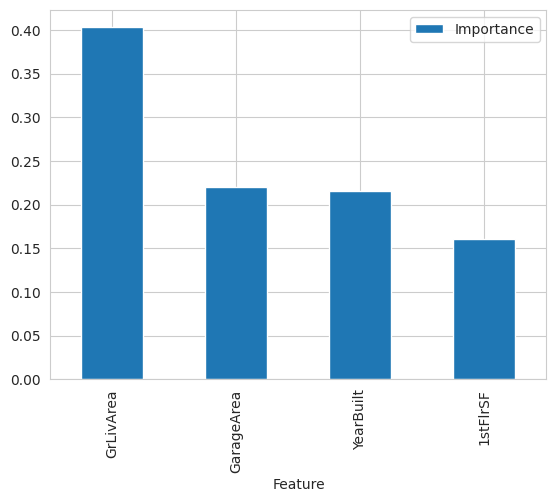

In [45]:
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# The most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Evaluate Performance on Train and Test datasets

Model Evaluation 

* Train Set
R2 Score: 0.97
Mean Absolute Error: 8525.305
Mean Squared Error: 186837667.172
Root Mean Squared Error: 13668.858


* Test Set
R2 Score: 0.783
Mean Absolute Error: 24153.815
Mean Squared Error: 1496472434.494
Root Mean Squared Error: 38684.266




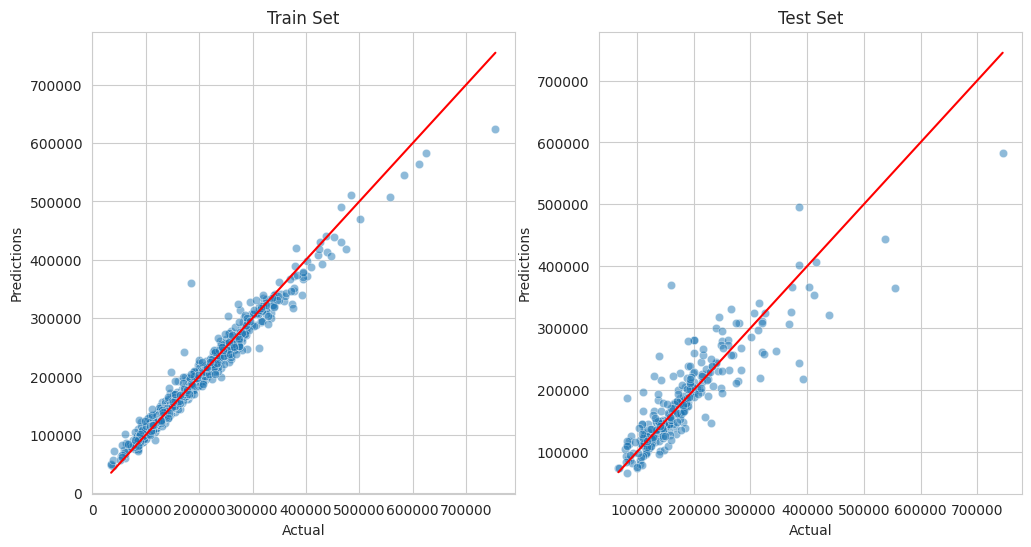

In [46]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Save datasets and models 

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* features importance plot

In [59]:
import os

version = 'v3'
file_path = f'outputs/ml_pipeline/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set : Features and Target

In [60]:
print(X_train.shape)
X_train.head()

(1168, 4)


,1stFlrSF,GarageArea,GrLivArea,YearBuilt
618,1828,774,1828,2007
870,894,308,894,1962
92,964,432,964,1921
817,1689,857,1689,2002
302,1541,843,1541,2001


In [61]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [62]:
print(y_train.shape)
y_train.head()

(1168,)


618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [63]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: Features and Target

In [64]:
print(X_test.shape)
X_test.head()

(292, 4)


,1stFlrSF,GarageArea,GrLivArea,YearBuilt
529,2515,484,2515,1957
491,958,240,1578,1941
459,979,352,1203,1950
279,1156,505,2022,1977
655,525,264,1092,1971


In [65]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [66]:
print(y_test.shape)
y_test.head()

(292,)


529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [67]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [68]:
best_regressor_pipeline

Pipeline(steps=[('NumericLogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=18, random_state=0))])

In [69]:
import joblib
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/v3/best_regressor_pipeline.pkl']

## Feature Importance Plot

In [70]:
df_feature_importance.to_csv(f"{file_path}/feature_importance.csv", index=False)

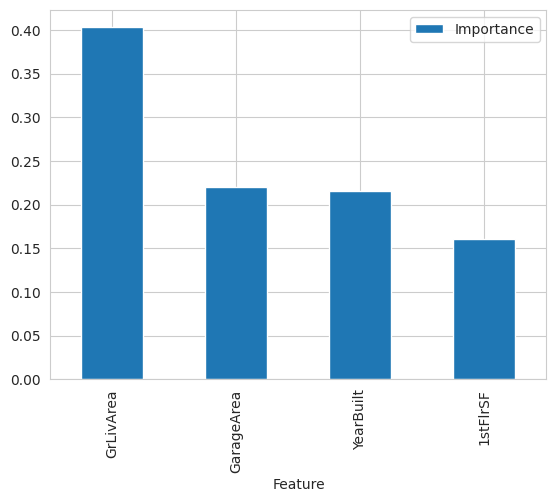

In [71]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')

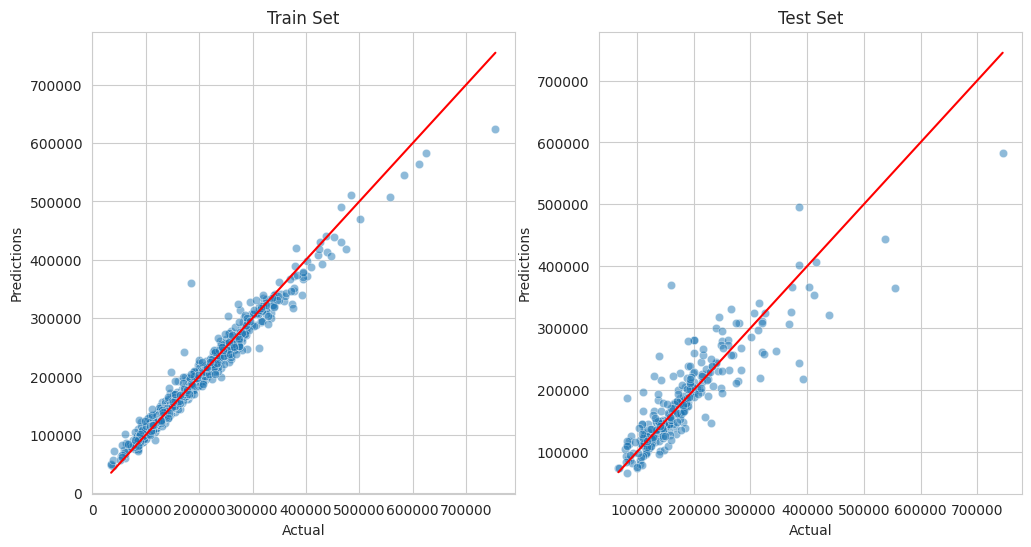

In [72]:
# regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)
pred_train = best_regressor_pipeline.predict(X_train)
pred_test = best_regressor_pipeline.predict(X_test)
alpha_scatter=0.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.savefig(f'{file_path}/regression_evaluation_plots.png', bbox_inches='tight')

---

## Conclusion

The following files were generated:

* Train set
* Test set
* Modeling pipeline
* features importance plot

* A Regressor model was chosen to predict sale price for a given property suggesting that feature selection and PCA produced close results that meet the business requirements. However, with a small margin we found that feature selction had better performance and was therefore chosen as the best pipeline for our buiness case. The following results were produce to meet our targets:

* Feature selection achieved an R2 Score: 0.97 on the train set and an R2 Score: 0.78 on the test set.

* The client requirement is for an R2 Score of 0.75\n"

